In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

def analyze_stock(ticker, start_date="2020-01-01", end_date="2025-01-01"):
    """
    Przeprowadza analizę techniczną akcji, obliczając kluczowe wskaźniki.
    
    Args:
        ticker (str): Symbol giełdowy akcji (np. "AAPL")
        start_date (str): Data początkowa w formacie "YYYY-MM-DD"
        end_date (str): Data końcowa w formacie "YYYY-MM-DD"
        
    Returns:
        pd.DataFrame: Ramka danych z obliczonymi wskaźnikami
    """
    # Pobieranie danych
    print(f"Pobieranie danych dla {ticker}...")
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    
    # Sprawdzenie, czy dane zostały pobrane
    if stock_data.empty:
        raise ValueError(f"Nie udało się pobrać danych dla {ticker}")
    
    print(f"Pobrano {len(stock_data)} dni danych")
    
    # Uproszczony dostęp do kolumn (bez multi-indexu)
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = stock_data.columns.map('_'.join)
    
    # Zmiana nazw kolumn na standardowe, jeśli są w formacie ticker
    column_mapping = {
        f'Open_{ticker}': 'Open',
        f'High_{ticker}': 'High', 
        f'Low_{ticker}': 'Low',
        f'Close_{ticker}': 'Close',
        f'Volume_{ticker}': 'Volume',
        'Open': 'Open',
        'High': 'High',
        'Low': 'Low',
        'Close': 'Close',
        'Volume': 'Volume',
        'Adj Close': 'Close'  # Mapujemy Adj Close na Close, jeśli istnieje
    }
    
    # Zachowaj tylko kolumny, które istnieją w danych
    existing_columns = {col: new_col for col, new_col in column_mapping.items() if col in stock_data.columns}
    stock_data = stock_data.rename(columns=existing_columns)
    
    # Podstawowe kolumny, które musimy mieć
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col not in stock_data.columns:
            raise ValueError(f"Brak wymaganej kolumny {col} w danych")
    
    # Obliczenia wskaźników
    print("Obliczanie wskaźników technicznych...")
    
    # 1. Średnie kroczące
    stock_data['MA_10'] = stock_data['Close'].rolling(window=10).mean()
    stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
    
    # 2. Dzienne stopy zwrotu
    stock_data['Daily_Return'] = stock_data['Close'].pct_change()
    
    # 3. RSI (Relative Strength Index)
    delta = stock_data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    stock_data['RSI'] = 100 - (100 / (1 + rs))
    
    # 4. Bollinger Bands
    stock_data['BB_Middle'] = stock_data['Close'].rolling(window=20).mean()
    std_dev = stock_data['Close'].rolling(window=20).std()
    stock_data['BB_Upper'] = stock_data['BB_Middle'] + 2 * std_dev
    stock_data['BB_Lower'] = stock_data['BB_Middle'] - 2 * std_dev
    
    # 5. MACD (Moving Average Convergence Divergence)
    short_ema = stock_data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = stock_data['Close'].ewm(span=26, adjust=False).mean()
    stock_data['MACD'] = short_ema - long_ema
    stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
    stock_data['MACD_Histogram'] = stock_data['MACD'] - stock_data['Signal_Line']
    
    # 6. ATR (Average True Range)
    high_low = stock_data['High'] - stock_data['Low']
    high_close = (stock_data['High'] - stock_data['Close'].shift()).abs()
    low_close = (stock_data['Low'] - stock_data['Close'].shift()).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    stock_data['ATR'] = true_range.rolling(window=14).mean()
    
    # 7. ADX (Average Directional Index)
    # Uproszczona wersja obliczania ADX
    plus_dm = stock_data['High'].diff()
    minus_dm = stock_data['Low'].diff()
    plus_dm = plus_dm.where(plus_dm > 0, 0)
    plus_dm = plus_dm.where((plus_dm > minus_dm.abs()) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where(minus_dm < 0, 0)
    minus_dm = minus_dm.abs().where((minus_dm.abs() > plus_dm) & (minus_dm < 0), 0)
    
    tr = true_range  # Wykorzystujemy już obliczony True Range
    
    plus_di = 100 * (plus_dm.rolling(window=14).mean() / tr.rolling(window=14).mean())
    minus_di = 100 * (minus_dm.abs().rolling(window=14).mean() / tr.rolling(window=14).mean())
    
    # Obsługa dzielenia przez zero i NaN
    dx = 100 * ((plus_di - minus_di).abs() / (plus_di + minus_di).where((plus_di + minus_di) != 0, 1e-7))
    stock_data['ADX'] = dx.rolling(window=14).mean()
    
    # 8. Sentiment Proxy (High/Low ratio)
    stock_data['Sentiment_Proxy'] = stock_data['High'] / stock_data['Low']
    
    # 9. Stochastic Oscillator (dodatkowy wskaźnik)
    low_14 = stock_data['Low'].rolling(window=14).min()
    high_14 = stock_data['High'].rolling(window=14).max()
    stock_data['Stochastic_K'] = 100 * ((stock_data['Close'] - low_14) / (high_14 - low_14))
    stock_data['Stochastic_D'] = stock_data['Stochastic_K'].rolling(window=3).mean()
    
    # Usunięcie wierszy z brakującymi wartościami (NaN)
    initial_len = len(stock_data)
    stock_data.dropna(inplace=True)
    print(f"Usunięto {initial_len - len(stock_data)} wierszy z brakującymi wartościami")
    
    # Zapisanie do pliku CSV
    csv_filename = f"{ticker}_technical_analysis.csv"
    stock_data.to_csv(csv_filename)
    print(f"Zapisano dane do {csv_filename}")
    
    return stock_data

# Przykład użycia
if __name__ == "__main__":
    # Możesz wybrać dowolny ticker: AAPL dla Apple, MSFT dla Microsoft, itp.
    ticker = "AAPL"
    results = analyze_stock(ticker)
    
    # Wyświetl podgląd danych
    print("\nPodgląd wyników analizy technicznej:")
    print(results.head())
    
    # Wyświetl podstawowe statystyki
    print("\nPodstawowe statystyki:")
    print(results[['Close', 'MA_50', 'RSI', 'MACD', 'ADX']].describe())

Pobieranie danych dla AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Pobrano 1258 dni danych
Obliczanie wskaźników technicznych...
Usunięto 199 wierszy z brakującymi wartościami
Zapisano dane do AAPL_technical_analysis.csv

Podgląd wyników analizy technicznej:
                 Close        High         Low        Open     Volume  \
Date                                                                    
2020-10-15  117.704178  118.181974  115.207927  115.763733  112559200   
2020-10-16  116.056252  118.523258  115.851482  118.259977  115393800   
2020-10-19  113.091957  117.421391  112.779926  116.972846  120639300   
2020-10-20  114.583870  116.017266  112.750679  113.306485  124423700   
2020-10-21  113.959793  115.753971  113.550246  113.764769   89946000   

                 MA_10       MA_50     MA_200  Daily_Return        RSI  ...  \
Date                                                                    ...   
2020-10-15  114.778874  114.007473  86.176185     -0.003961  63.102245  ...   
2020-10-16  115.363933  114.111272  86.392885     -0.014001

Wczytywanie danych Apple...
Wczytano 1059 wierszy danych
Tworzenie opóźnionych wskaźników...
Po usunięciu brakujących wartości: 1056 wierszy
Liczba cech przed skalowaniem: 25
Liczba cech po PCA: 9
Wyjaśniona wariancja: 0.95

Trening modelu: SVM
Najlepsze parametry: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Dokładność: 0.6398
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       110
           1       0.61      0.71      0.65       101

    accuracy                           0.64       211
   macro avg       0.64      0.64      0.64       211
weighted avg       0.65      0.64      0.64       211


Trening modelu: Gradient Boosting
Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Dokładność: 0.5972
              precision    recall  f1-score   support

           0       0.68      0.44      0.53       110
           1       0.56      0.77      0.65       101

    accuracy                           0.60  

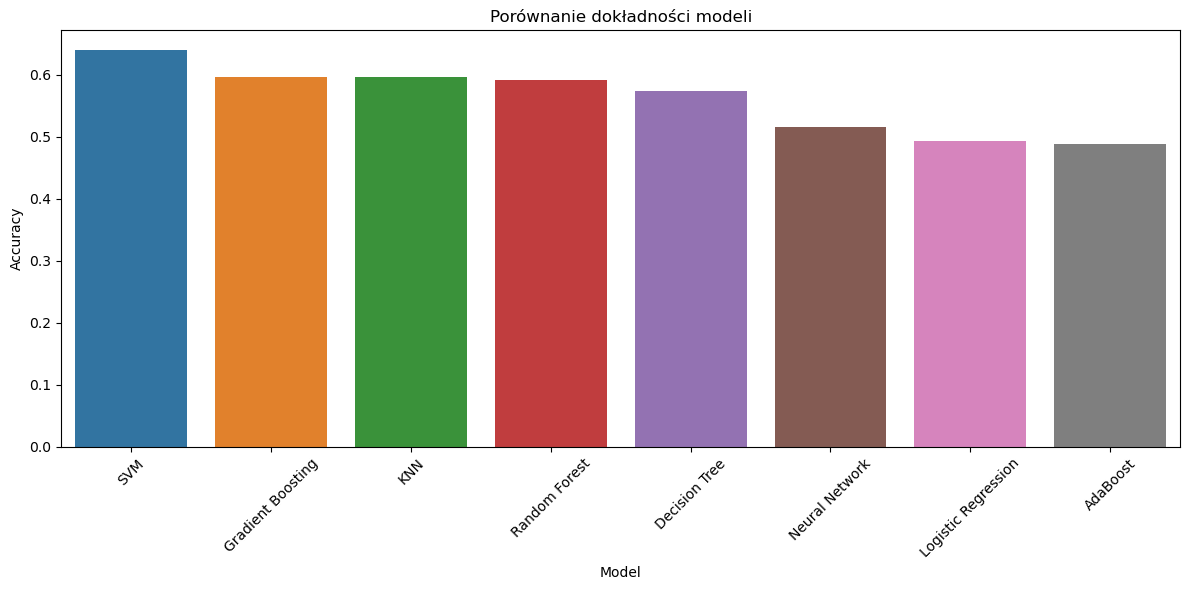

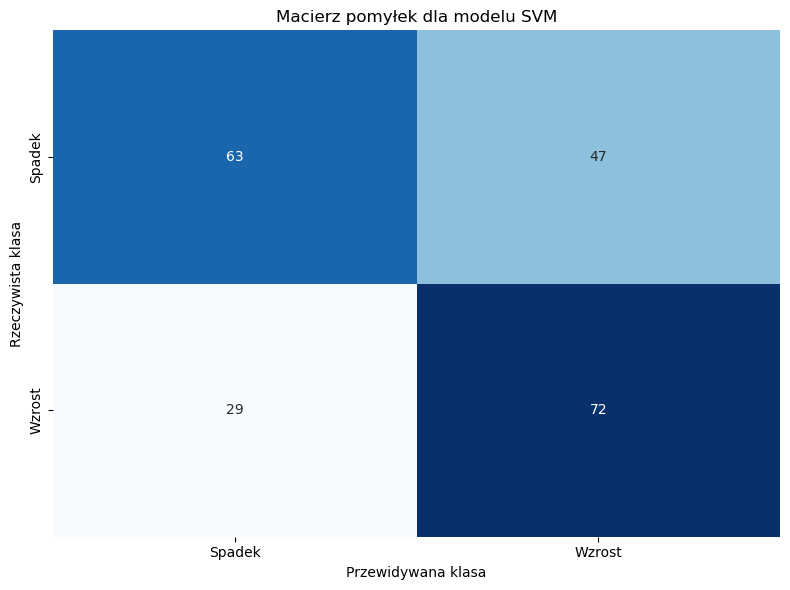

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Modele uczenia maszynowego dostępne w scikit-learn
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Wczytanie danych
print("Wczytywanie danych Apple...")
apple_data = pd.read_csv("AAPL_technical_analysis.csv", index_col=0, parse_dates=True)
print(f"Wczytano {len(apple_data)} wierszy danych")

# Feature Engineering: Adding Lag Features
print("Tworzenie opóźnionych wskaźników...")
for lag in range(1, 4):
    apple_data[f'RSI_Lag_{lag}'] = apple_data['RSI'].shift(lag)
    apple_data[f'MACD_Lag_{lag}'] = apple_data['MACD'].shift(lag)
    apple_data[f'ADX_Lag_{lag}'] = apple_data['ADX'].shift(lag)
    
# Dodajmy też inne wskaźniki opóźnione, które mogą być przydatne
for lag in range(1, 4):
    apple_data[f'Close_Pct_Change_Lag_{lag}'] = apple_data['Close'].pct_change(lag)
    apple_data[f'Volume_Pct_Change_Lag_{lag}'] = apple_data['Volume'].pct_change(lag)
    apple_data[f'ATR_Lag_{lag}'] = apple_data['ATR'].shift(lag)

apple_data.dropna(inplace=True)
print(f"Po usunięciu brakujących wartości: {len(apple_data)} wierszy")

# Dodatkowe cechy oparte na różnicach wskaźników
apple_data['RSI_Change'] = apple_data['RSI'] - apple_data['RSI_Lag_1']
apple_data['MACD_Change'] = apple_data['MACD'] - apple_data['MACD_Lag_1']
apple_data['ADX_Change'] = apple_data['ADX'] - apple_data['ADX_Lag_1']
apple_data['MA_Cross'] = np.where(apple_data['MA_10'] > apple_data['MA_50'], 1, -1)

# Prepare data for modeling
features = [
    'MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
    'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
    'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3', 'RSI_Change', 'MACD_Change', 'ADX_Change',
    'MA_Cross', 'Close_Pct_Change_Lag_1', 'Volume_Pct_Change_Lag_1', 'ATR_Lag_1'
]

print(f"Liczba cech przed skalowaniem: {len(features)}")
X = apple_data[features]

# Skalowanie cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Zachowaj 95% wariancji
X_pca = pca.fit_transform(X_scaled)
print(f"Liczba cech po PCA: {X_pca.shape[1]}")
print(f"Wyjaśniona wariancja: {sum(pca.explained_variance_ratio_):.2f}")

# Prepare target variable (3-day forward prediction)
apple_data['Target_Up'] = np.where(apple_data['Close'].shift(-3) > apple_data['Close'], 1, 0)
apple_data['Target_Pct_Change'] = apple_data['Close'].shift(-3) / apple_data['Close'] - 1

# Ensure feature and target sizes match
X_pca = X_pca[:-3]
y_binary = apple_data['Target_Up'].iloc[:-3].values
y_continuous = apple_data['Target_Pct_Change'].iloc[:-3].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_binary, test_size=0.2, random_state=42)

# Lista modeli do porównania (bez Neural Network)
models = {
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Uproszczone parametry (mniejsza przestrzeń przeszukiwania)
param_grids = {
    'SVM': {
        'C': [1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    'Gradient Boosting': {
        'learning_rate': [0.1],
        'n_estimators': [100],
        'max_depth': [3, 5]
    },
    'Logistic Regression': {
        'C': [0.1, 1],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [100],
        'max_depth': [None, 10]
    },
    'AdaBoost': {
        'n_estimators': [50],
        'learning_rate': [0.1, 1.0]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'Decision Tree': {
        'max_depth': [None, 5],
        'min_samples_split': [2, 5]
    }
}

# Porównanie modeli
results = {}
best_models = {}

for name, model in models.items():
    print(f"\nTrening modelu: {name}")
    
    # Używamy 2-krotnej walidacji krzyżowej zamiast 3-krotnej dla szybszego treningu
    grid = GridSearchCV(model, param_grids[name], cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    y_pred = grid.best_estimator_.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"Najlepsze parametry: {grid.best_params_}")
    print(f"Dokładność: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Dodajemy Neural Network jako oddzielny model z uproszczonymi parametrami
print("\nTrening modelu: Neural Network (uproszczony)")
nn_model = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    alpha=0.001,
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred_nn)
results['Neural Network'] = nn_accuracy
best_models['Neural Network'] = nn_model

print(f"Dokładność: {nn_accuracy:.4f}")
print(classification_report(y_test, y_pred_nn))

# Wybór najlepszego modelu
best_model_name = max(results, key=results.get)
best_model = best_models[best_model_name]

print(f"\nNajlepszy model: {best_model_name} z dokładnością {results[best_model_name]:.4f}")

# Wizualizacja wyników
plt.figure(figsize=(12, 6))
models_df = pd.DataFrame({'Model': list(results.keys()), 'Accuracy': list(results.values())})
models_df = models_df.sort_values('Accuracy', ascending=False)
sns.barplot(x='Model', y='Accuracy', data=models_df)
plt.title('Porównanie dokładności modeli')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')

# Macierz pomyłek dla najlepszego modelu
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Spadek', 'Wzrost'],
            yticklabels=['Spadek', 'Wzrost'])
plt.xlabel('Przewidywana klasa')
plt.ylabel('Rzeczywista klasa')
plt.title(f'Macierz pomyłek dla modelu {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# Zapisz najlepszy model
import joblib
joblib.dump(best_model, f'best_model_{best_model_name}.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(pca, 'pca_transform.pkl')

print(f"\nZapisano najlepszy model: best_model_{best_model_name}.pkl")
print("Zapisano transformacje: feature_scaler.pkl, pca_transform.pkl")

# Funkcja do przewidywania dla nowych danych
def predict_price_movement(new_data, scaler, pca, model):
    """
    Przewiduje kierunek ruchu ceny za 3 dni.
    
    Args:
        new_data (pd.DataFrame): Dane z cechami
        scaler (StandardScaler): Obiekt do skalowania cech
        pca (PCA): Obiekt do transformacji PCA
        model: Wytrenowany model
        
    Returns:
        np.array: Przewidywane prawdopodobieństwa wzrostu ceny
    """
    X_new_scaled = scaler.transform(new_data)
    X_new_pca = pca.transform(X_new_scaled)
    probas = model.predict_proba(X_new_pca)
    return probas[:, 1]  # Zwraca prawdopodobieństwo wzrostu

# Przykład wykorzystania funkcji (na ostatnich dostępnych danych)
last_available_data = apple_data[features].iloc[-4:-1]  # Ostatnie 3 wiersze z pełnymi danymi
probabilities = predict_price_movement(last_available_data, scaler, pca, best_model)

print("\nPrzykładowe przewidywania dla ostatnich dostępnych dni:")
for i, idx in enumerate(last_available_data.index):
    print(f"Data: {idx.strftime('%Y-%m-%d')}, Prawdopodobieństwo wzrostu: {probabilities[i]:.4f}")

# Dodawanie przewidywań do danych
print("\nDodawanie przewidywań do danych i zapisywanie do pliku CSV...")

# Przewidywanie dla wszystkich dostępnych danych
all_predictions = []
for i in range(len(apple_data) - 3):  # Pomijamy ostatnie 3 dni, dla których nie mamy rzeczywistych wartości
    data_slice = apple_data[features].iloc[i:i+1]
    try:
        pred_probability = predict_price_movement(data_slice, scaler, pca, best_model)[0]
        all_predictions.append(pred_probability)
    except Exception as e:
        print(f"Błąd dla indeksu {i}: {e}")
        all_predictions.append(np.nan)

# Tworzymy kopię danych, aby nie modyfikować oryginału
apple_data_with_predictions = apple_data.copy()

# Dodajemy przewidywania
apple_data_with_predictions['Prediction_Probability'] = np.nan  # Inicjalizujemy kolumnę wartościami NaN
apple_data_with_predictions.iloc[:-3, -1] = all_predictions  # Dodajemy przewidywania do wszystkich oprócz ostatnich 3 dni

# Dodajemy wyniki predykcji jako binarną klasyfikację
apple_data_with_predictions['Prediction_Direction'] = np.where(
    apple_data_with_predictions['Prediction_Probability'] > 0.5, 1, 0
)

# Obliczamy, czy predykcja była poprawna (1) czy błędna (0)
apple_data_with_predictions['Prediction_Correct'] = np.where(
    apple_data_with_predictions['Prediction_Direction'] == apple_data_with_predictions['Target_Up'], 1, 0
)

# Zapisujemy do pliku CSV
apple_data_with_predictions.to_csv('apple_data_updated.csv')
print("Zapisano dane z przewidywaniami do pliku 'apple_data_updated.csv'")

# Obliczamy ogólną skuteczność modelu
correct_predictions = apple_data_with_predictions['Prediction_Correct'].sum()
total_predictions = apple_data_with_predictions['Prediction_Correct'].count()
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

print(f"\nOgólna skuteczność modelu na wszystkich danych: {accuracy:.4f} ({correct_predictions}/{total_predictions})")

# Obliczamy skuteczność dla wzrostów i spadków osobno
up_mask = apple_data_with_predictions['Target_Up'] == 1
up_correct = apple_data_with_predictions.loc[up_mask, 'Prediction_Correct'].sum()
up_total = up_mask.sum()
up_accuracy = up_correct / up_total if up_total > 0 else 0

down_mask = apple_data_with_predictions['Target_Up'] == 0
down_correct = apple_data_with_predictions.loc[down_mask, 'Prediction_Correct'].sum()
down_total = down_mask.sum()
down_accuracy = down_correct / down_total if down_total > 0 else 0

print(f"Skuteczność dla przewidywania wzrostów: {up_accuracy:.4f} ({up_correct}/{up_total})")
print(f"Skuteczność dla przewidywania spadków: {down_accuracy:.4f} ({down_correct}/{down_total})")

Wczytywanie przetworzonych danych Apple...
Wczytano 1056 wierszy danych
Dostępne cechy: 25 z 25
Liczba cech przed skalowaniem: 25
Liczba cech po PCA: 9
Wyjaśniona wariancja: 0.95

Trening modelu: SVM
Najlepsze parametry: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Dokładność: 0.6398
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       110
           1       0.61      0.71      0.65       101

    accuracy                           0.64       211
   macro avg       0.64      0.64      0.64       211
weighted avg       0.65      0.64      0.64       211


Trening modelu: Gradient Boosting
Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Dokładność: 0.5972
              precision    recall  f1-score   support

           0       0.68      0.44      0.53       110
           1       0.56      0.77      0.65       101

    accuracy                           0.60       211
   macro avg       0.62      0.60   

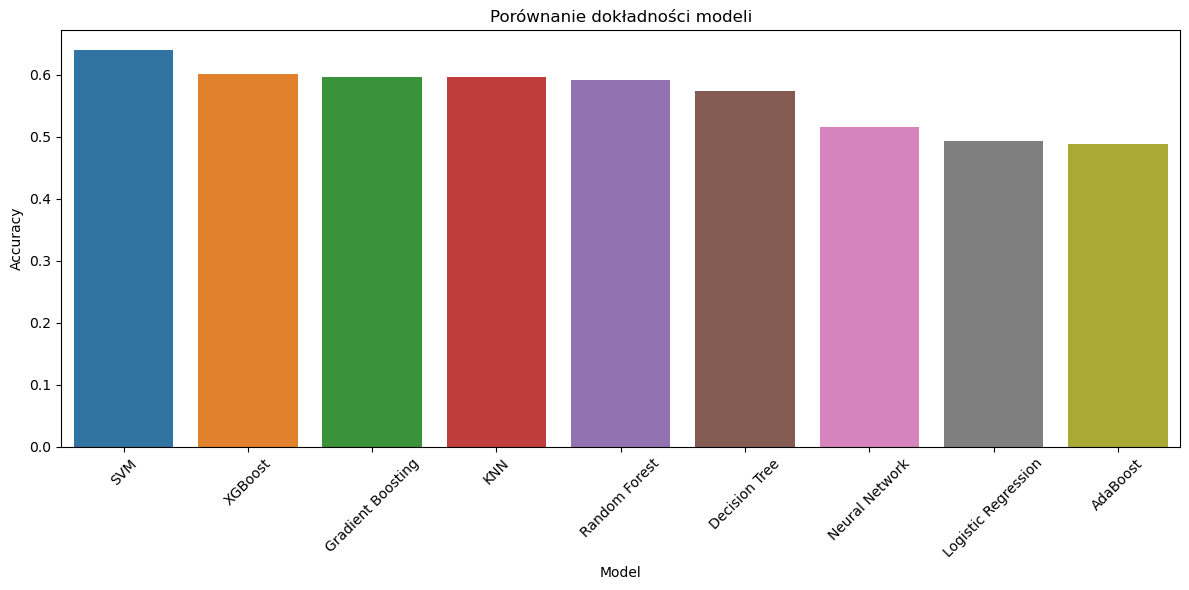

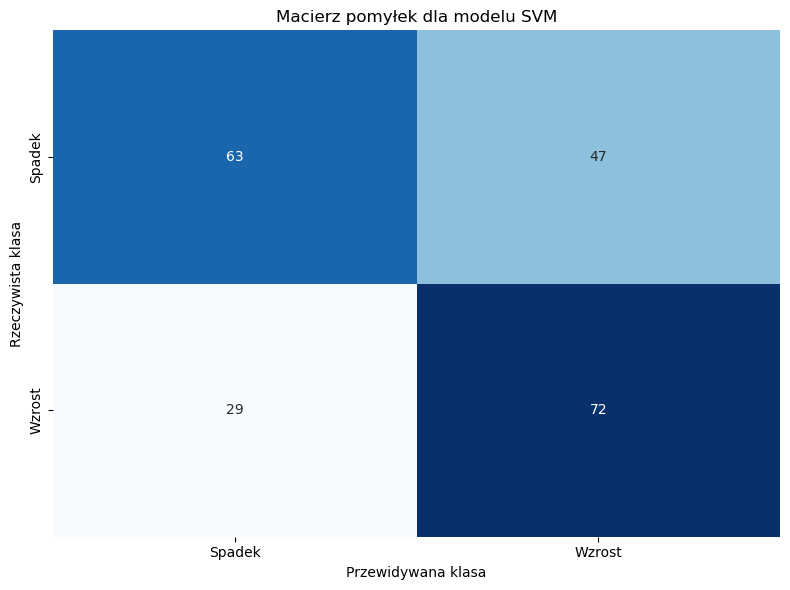

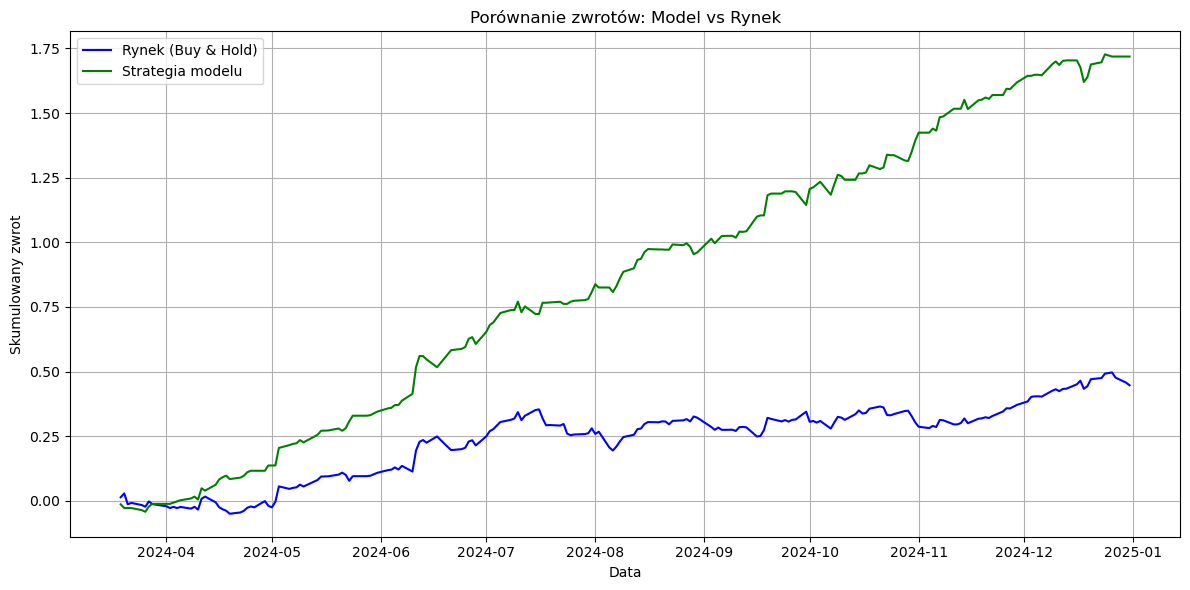

<Figure size 1400x700 with 0 Axes>

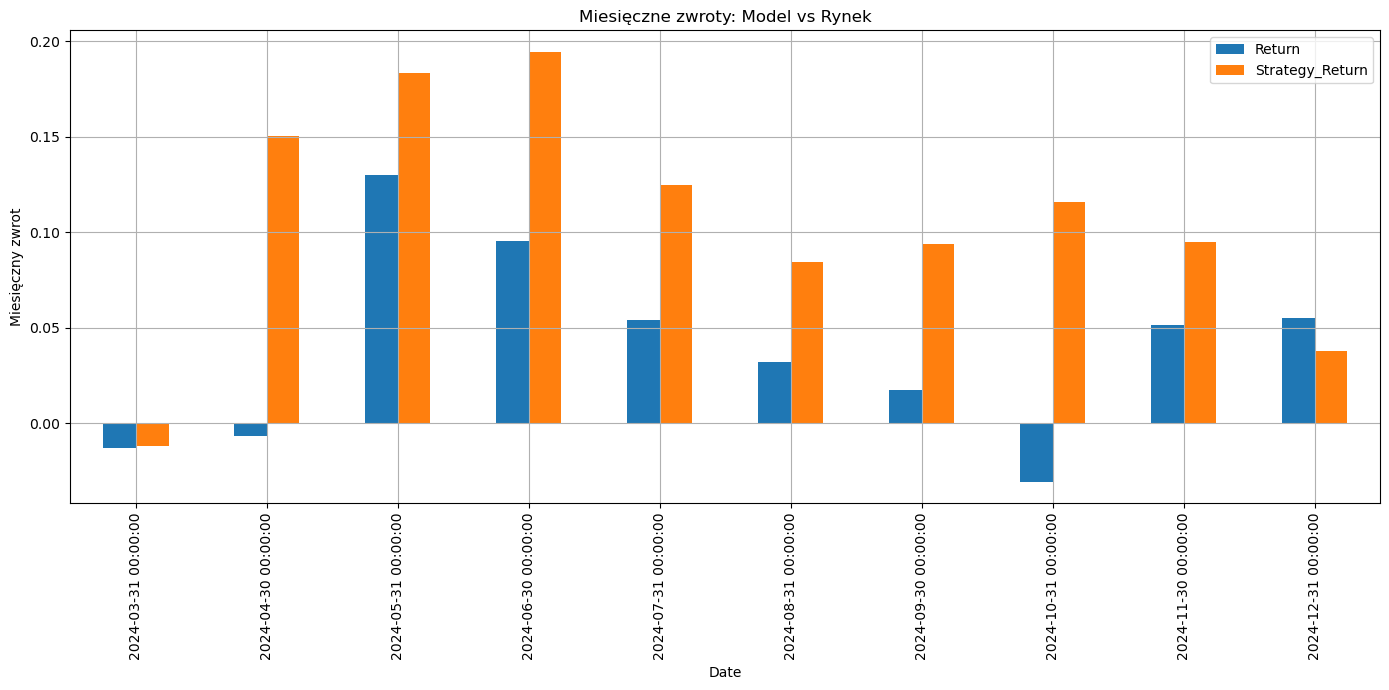

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Modele uczenia maszynowego dostępne w scikit-learn
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Wczytanie danych
print("Wczytywanie przetworzonych danych Apple...")
apple_data = pd.read_csv("apple_data_updated.csv", index_col=0, parse_dates=True)
print(f"Wczytano {len(apple_data)} wierszy danych")

# Definiujemy cechy do modelu - używamy tych samych co w oryginalnym kodzie
features = [
    'MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
    'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
    'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3', 'RSI_Change', 'MACD_Change', 'ADX_Change',
    'MA_Cross', 'Close_Pct_Change_Lag_1', 'Volume_Pct_Change_Lag_1', 'ATR_Lag_1'
]

# Sprawdzamy, które cechy są dostępne
available_features = [f for f in features if f in apple_data.columns]
print(f"Dostępne cechy: {len(available_features)} z {len(features)}")

print(f"Liczba cech przed skalowaniem: {len(available_features)}")
X = apple_data[available_features].dropna()
y = apple_data.loc[X.index, 'Target_Up']

# Skalowanie cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Redukcja wymiarowości z PCA
pca = PCA(n_components=0.95)  # Zachowaj 95% wariancji
X_pca = pca.fit_transform(X_scaled)
print(f"Liczba cech po PCA: {X_pca.shape[1]}")
print(f"Wyjaśniona wariancja: {sum(pca.explained_variance_ratio_):.2f}")

# Przygotowanie zmiennej celu (3-dniowej predykcji)
# Zapewniamy, że rozmiary danych cech i celu są zgodne
X_pca = X_pca[:-3]  # Pomijamy ostatnie 3 dni, dla których nie mamy przyszłych wartości
y = y.iloc[:-3]     # To samo dla celu

# Podział danych na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Lista modeli do porównania
models = {
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Parametry do strojenia dla każdego modelu
param_grids = {
    'SVM': {
        'C': [1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    'Gradient Boosting': {
        'learning_rate': [0.1],
        'n_estimators': [100],
        'max_depth': [3, 5]
    },
    'Logistic Regression': {
        'C': [0.1, 1],
        'solver': ['liblinear']
    },
    'Random Forest': {
        'n_estimators': [100],
        'max_depth': [None, 10]
    },
    'AdaBoost': {
        'n_estimators': [50],
        'learning_rate': [0.1, 1.0]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    'Decision Tree': {
        'max_depth': [None, 5],
        'min_samples_split': [2, 5]
    }
}

# Porównanie modeli
results = {}
best_models = {}

for name, model in models.items():
    print(f"\nTrening modelu: {name}")
    
    # Używamy 2-krotnej walidacji krzyżowej dla szybszego treningu
    grid = GridSearchCV(model, param_grids[name], cv=2, scoring='accuracy')
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_
    y_pred = grid.best_estimator_.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    
    print(f"Najlepsze parametry: {grid.best_params_}")
    print(f"Dokładność: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Dodajemy Neural Network jako oddzielny model z uproszczonymi parametrami
print("\nTrening modelu: Neural Network (uproszczony)")
nn_model = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    alpha=0.001,
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred_nn)
results['Neural Network'] = nn_accuracy
best_models['Neural Network'] = nn_model

print(f"Dokładność: {nn_accuracy:.4f}")
print(classification_report(y_test, y_pred_nn))

# Dodajemy XGBoost
print("\nTrening modelu: XGBoost")
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model, 
    xgb_params, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy', 
    random_state=42, 
    verbose=1
)

xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
results['XGBoost'] = xgb_accuracy
best_models['XGBoost'] = xgb_best

print(f"Najlepsze parametry XGBoost: {xgb_search.best_params_}")
print(f"Dokładność XGBoost: {xgb_accuracy:.4f}")
print(classification_report(y_test, xgb_pred))

# Wybór najlepszego modelu
best_model_name = max(results, key=results.get)
best_model = best_models[best_model_name]

print(f"\nNajlepszy model: {best_model_name} z dokładnością {results[best_model_name]:.4f}")

# Wizualizacja wyników
plt.figure(figsize=(12, 6))
models_df = pd.DataFrame({'Model': list(results.keys()), 'Accuracy': list(results.values())})
models_df = models_df.sort_values('Accuracy', ascending=False)
sns.barplot(x='Model', y='Accuracy', data=models_df)
plt.title('Porównanie dokładności modeli')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')

# Macierz pomyłek dla najlepszego modelu
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Spadek', 'Wzrost'],
            yticklabels=['Spadek', 'Wzrost'])
plt.xlabel('Przewidywana klasa')
plt.ylabel('Rzeczywista klasa')
plt.title(f'Macierz pomyłek dla modelu {best_model_name}')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# Zapisz najlepszy model
joblib.dump(best_model, f'best_model_{best_model_name}.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(pca, 'pca_transform.pkl')

print(f"\nZapisano najlepszy model: best_model_{best_model_name}.pkl")
print("Zapisano transformacje: feature_scaler.pkl, pca_transform.pkl")

# Funkcja do przewidywania dla nowych danych
def predict_price_movement(new_data, scaler, pca, model):
    """
    Przewiduje kierunek ruchu ceny za 3 dni.
    
    Args:
        new_data (pd.DataFrame): Dane z cechami
        scaler (StandardScaler): Obiekt do skalowania cech
        pca (PCA): Obiekt do transformacji PCA
        model: Wytrenowany model
        
    Returns:
        np.array: Przewidywane prawdopodobieństwa wzrostu ceny
    """
    X_new_scaled = scaler.transform(new_data)
    X_new_pca = pca.transform(X_new_scaled)
    probas = model.predict_proba(X_new_pca)
    return probas[:, 1]  # Zwraca prawdopodobieństwo wzrostu

# Przykład wykorzystania funkcji (na ostatnich dostępnych danych)
last_available_data = X.iloc[-4:-1]  # Ostatnie 3 wiersze z pełnymi danymi
probabilities = predict_price_movement(last_available_data, scaler, pca, best_model)

print("\nPrzykładowe przewidywania dla ostatnich dostępnych dni:")
for i, idx in enumerate(last_available_data.index):
    print(f"Data: {idx.strftime('%Y-%m-%d')}, Prawdopodobieństwo wzrostu: {probabilities[i]:.4f}")

# Porównanie skuteczności z XGBoost (alternatywna implementacja)
# Trenujemy oddzielnie model XGBoost z bardziej rozbudowanymi parametrami
print("\nTrening rozbudowanego modelu XGBoost...")
xgb_advanced = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Trenujemy model bezpośrednio, bez przeszukiwania siatki
xgb_advanced.fit(X_train, y_train)
xgb_advanced_pred = xgb_advanced.predict(X_test)
xgb_advanced_accuracy = accuracy_score(y_test, xgb_advanced_pred)
print(f"Dokładność rozbudowanego XGBoost: {xgb_advanced_accuracy:.4f}")
print(classification_report(y_test, xgb_advanced_pred))

# Zapisz również model XGBoost
joblib.dump(xgb_advanced, 'xgb_advanced_model.pkl')
print("Zapisano rozbudowany model XGBoost: xgb_advanced_model.pkl")

print("\nAnaliza strategii inwestycyjnej:")
# Symulacja strategii inwestycyjnej opartej na najlepszym modelu
# Bierzemy ostatnie 200 dni danych
simulation_data = apple_data.iloc[-200:].copy()
simulation_data['Prediction'] = np.nan

# Obliczamy predykcje dla tych danych
for i in range(len(simulation_data) - 3):
    data_slice = simulation_data.iloc[i:i+1][available_features]
    if not data_slice.isnull().values.any():
        try:
            pred_probability = predict_price_movement(data_slice, scaler, pca, best_model)[0]
            simulation_data.iloc[i, simulation_data.columns.get_loc('Prediction')] = pred_probability
        except Exception as e:
            print(f"Błąd dla indeksu {i}: {e}")

# Tworzymy sygnały kupna/sprzedaży
simulation_data['Signal'] = np.where(simulation_data['Prediction'] > 0.6, 1, 
                                     np.where(simulation_data['Prediction'] < 0.4, -1, 0))

# Obliczamy zwroty
simulation_data['Return'] = simulation_data['Close'].pct_change()
simulation_data['Strategy_Return'] = simulation_data['Signal'].shift(1) * simulation_data['Return']

# Obliczamy skumulowane zwroty
simulation_data['Cumulative_Market_Return'] = (1 + simulation_data['Return']).cumprod() - 1
simulation_data['Cumulative_Strategy_Return'] = (1 + simulation_data['Strategy_Return']).cumprod() - 1

# Wyliczanie metryk
trading_days = len(simulation_data) - simulation_data['Signal'].isna().sum() - 1
n_trades = (simulation_data['Signal'].diff() != 0).sum()
avg_return_per_trade = simulation_data['Strategy_Return'].sum() / n_trades if n_trades > 0 else 0
strategy_sharpe = simulation_data['Strategy_Return'].mean() / simulation_data['Strategy_Return'].std() * np.sqrt(252) if simulation_data['Strategy_Return'].std() > 0 else 0

print(f"Liczba dni handlowych: {trading_days}")
print(f"Liczba transakcji: {n_trades}")
print(f"Średni zwrot z transakcji: {avg_return_per_trade:.4f}")
print(f"Sharpe Ratio strategii: {strategy_sharpe:.4f}")
print(f"Skumulowany zwrot rynkowy: {simulation_data['Cumulative_Market_Return'].iloc[-1]:.4f}")
print(f"Skumulowany zwrot strategii: {simulation_data['Cumulative_Strategy_Return'].iloc[-1]:.4f}")

# Wizualizacja wyników
plt.figure(figsize=(12, 6))
plt.plot(simulation_data.index, simulation_data['Cumulative_Market_Return'], 'b-', label='Rynek (Buy & Hold)')
plt.plot(simulation_data.index, simulation_data['Cumulative_Strategy_Return'], 'g-', label='Strategia modelu')
plt.title('Porównanie zwrotów: Model vs Rynek')
plt.xlabel('Data')
plt.ylabel('Skumulowany zwrot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('strategy_returns.png')

# Wizualizacja miesięcznych zwrotów
monthly_returns = simulation_data.resample('M').apply({
    'Return': lambda x: (1 + x).prod() - 1,
    'Strategy_Return': lambda x: (1 + x).prod() - 1
})

plt.figure(figsize=(14, 7))
monthly_returns[['Return', 'Strategy_Return']].plot(kind='bar', figsize=(14, 7))
plt.title('Miesięczne zwroty: Model vs Rynek')
plt.ylabel('Miesięczny zwrot')
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_returns.png')

print("\nAnalizę zakończono. Wykresy zostały zapisane.")
print("\nZnaczenie cech w najlepszym modelu:")

# Sprawdź czy najlepszy model posiada atrybut feature_importances_
if hasattr(best_model, 'feature_importances_'):
    # Wizualizacja ważności cech dla modeli drzewiastych
    feature_importances = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), np.array(range(X_pca.shape[1]))[sorted_idx])
    plt.xlabel('Ważność cechy')
    plt.title(f'Ważność cech dla modelu {best_model_name} (komponenty PCA)')
    plt.tight_layout()
    plt.savefig('feature_importance_pca.png')
elif best_model_name == 'SVM' and hasattr(best_model, 'coef_'):
    # Dla modeli liniowych jak SVM z liniowym kernelem
    coefs = best_model.coef_[0]
    sorted_idx = np.argsort(np.abs(coefs))
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), np.abs(coefs[sorted_idx]))
    plt.yticks(range(len(sorted_idx)), np.array(range(X_pca.shape[1]))[sorted_idx])
    plt.xlabel('Ważność cechy (wartość bezwzględna współczynnika)')
    plt.title(f'Ważność cech dla modelu {best_model_name} (komponenty PCA)')
    plt.tight_layout()
    plt.savefig('feature_importance_pca.png')

Wczytywanie danych Apple...
Wczytano 1056 wierszy danych
Używam 18 z 18 planowanych cech
Używam kolumny celu: Target_Up
Starting Random Forest Optimization...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest tuning complete.
Najlepsze parametry RF: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced_subsample'}
Dokładność Random Forest: 0.6825
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       110
           1       0.65      0.73      0.69       101

    accuracy                           0.68       211
   macro avg       0.69      0.68      0.68       211
weighted avg       0.69      0.68      0.68       211


Starting XGBoost Optimization...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\S\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost tuning complete.
Najlepsze parametry XGB: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Dokładność XGBoost: 0.6303
              precision    recall  f1-score   support

           0       0.69      0.54      0.60       110
           1       0.59      0.73      0.65       101

    accuracy                           0.63       211
   macro avg       0.64      0.63      0.63       211
weighted avg       0.64      0.63      0.63       211


Starting Random Forest Backtest...
Backtest using: RandomForestClassifier
Total buy signals: 593 out of 1053 (56.3%)
2020-10-26: BUY EXECUTED, Price: 112.19, Size: 846, Cash: 100000.00, Prob: 0.61
Strategy finished with 1 trade signals
Random Forest Backtest Complete.
Starting Portfolio Value: $100000.00
Final Portfolio Value: $223046.28
Total Return: 80.22%
Sharpe Ratio: 0.7693
Maximum Drawdown: 30.09%
Total Trades: 1

Starting X

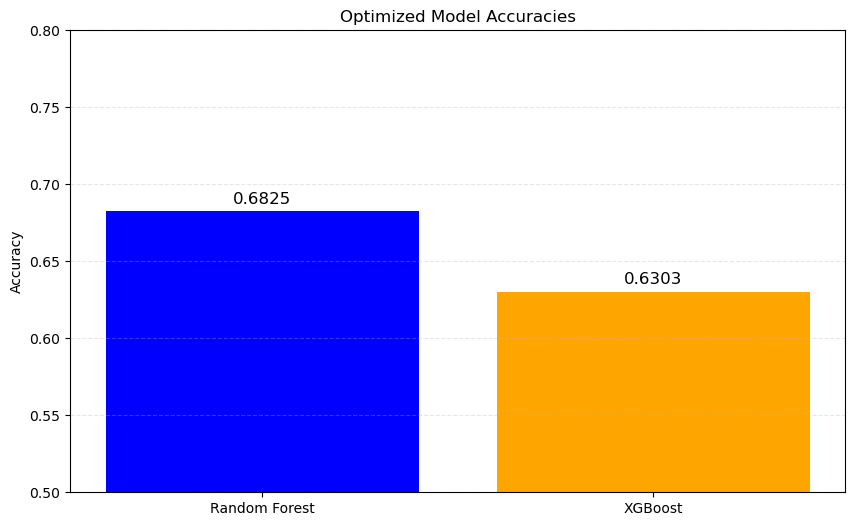

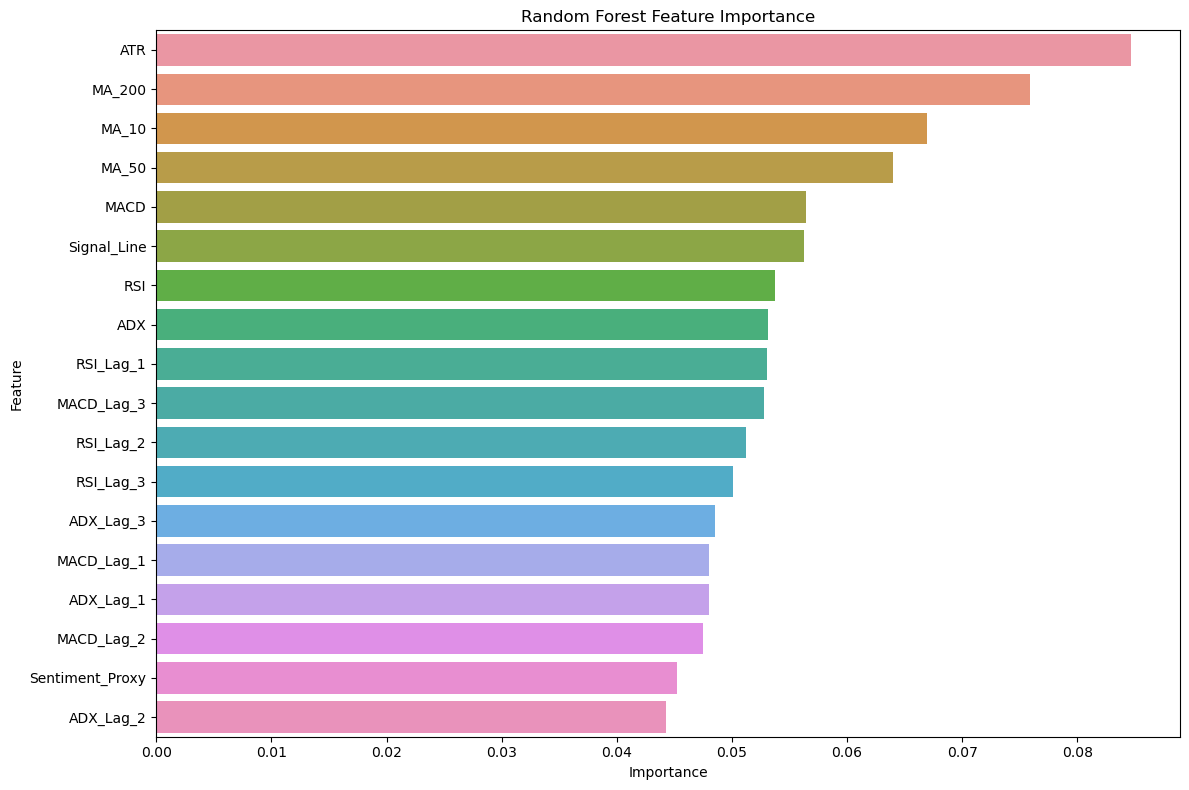

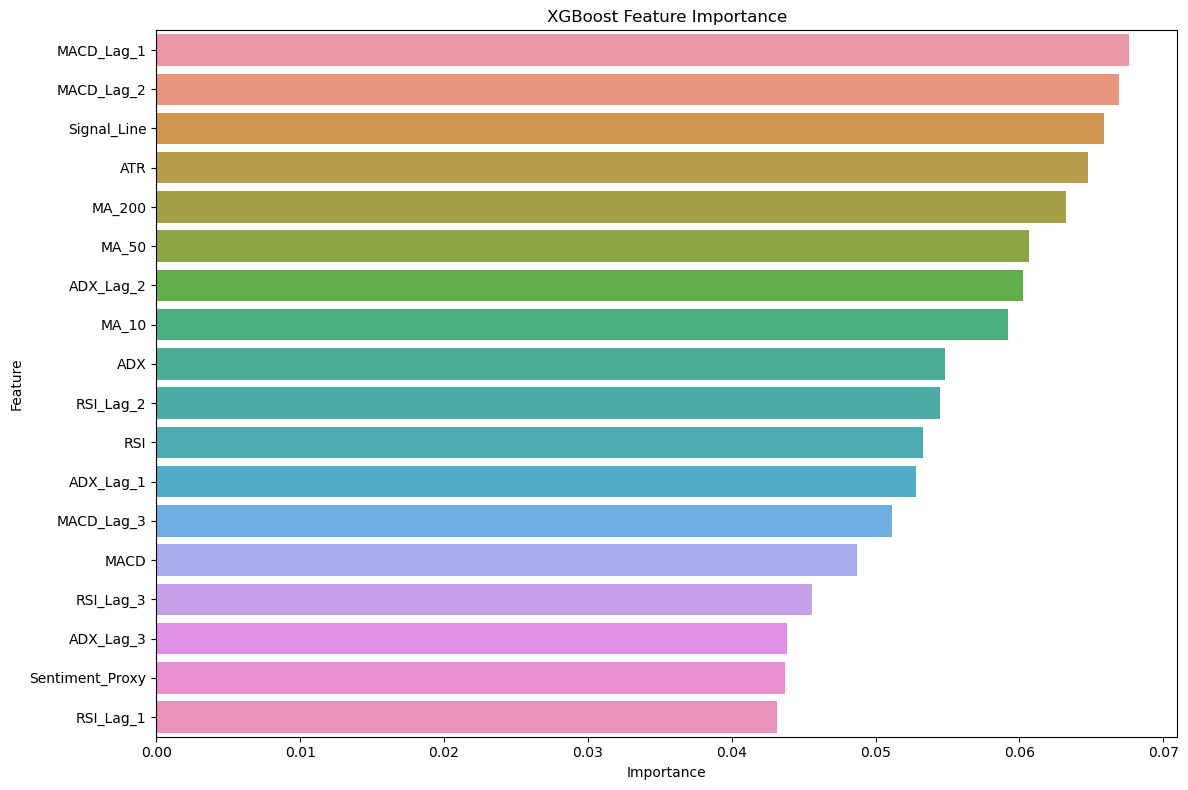

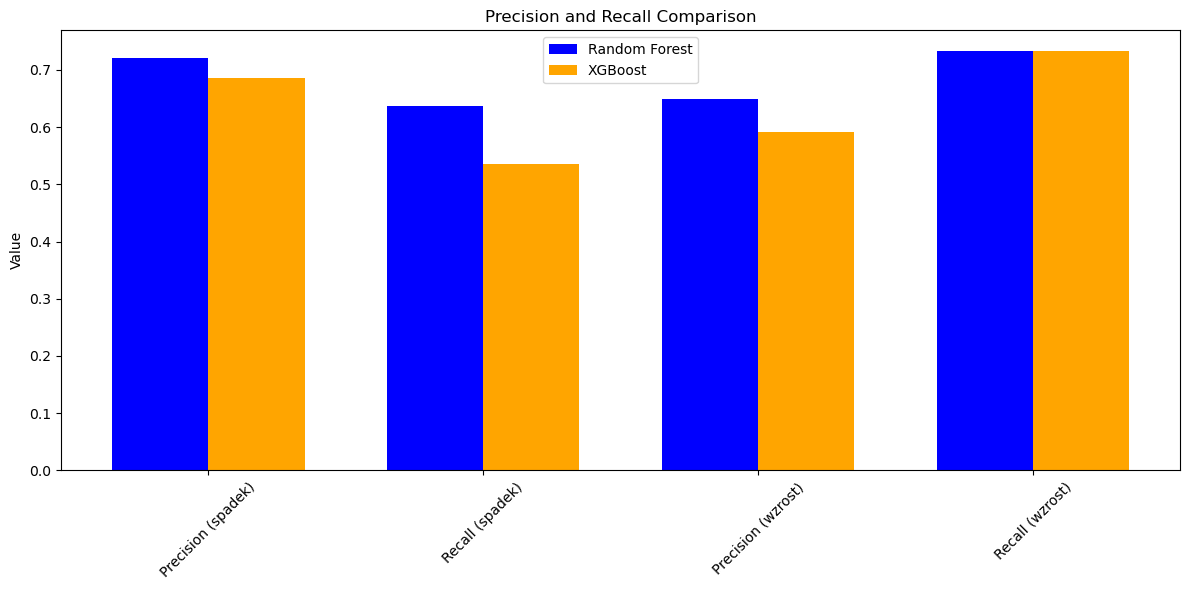

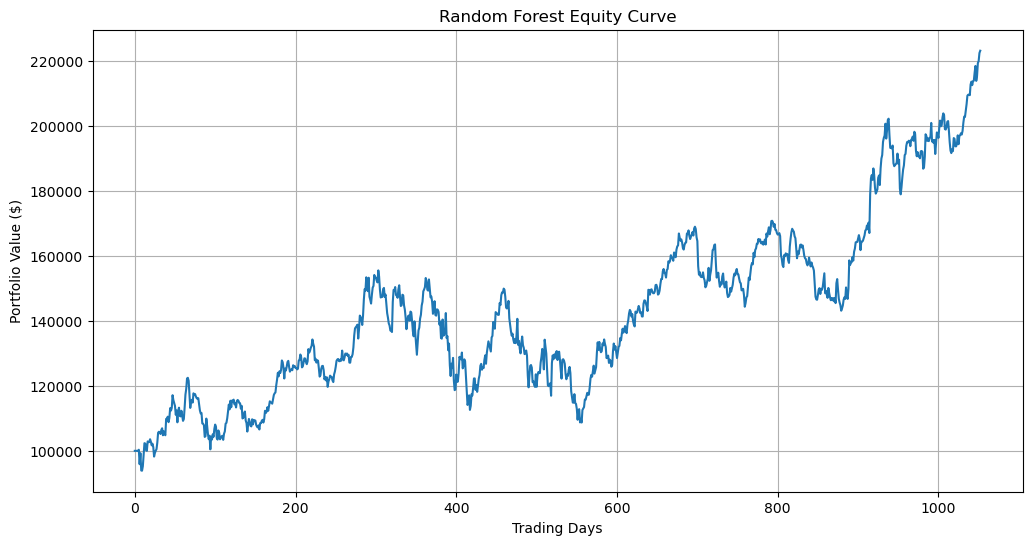

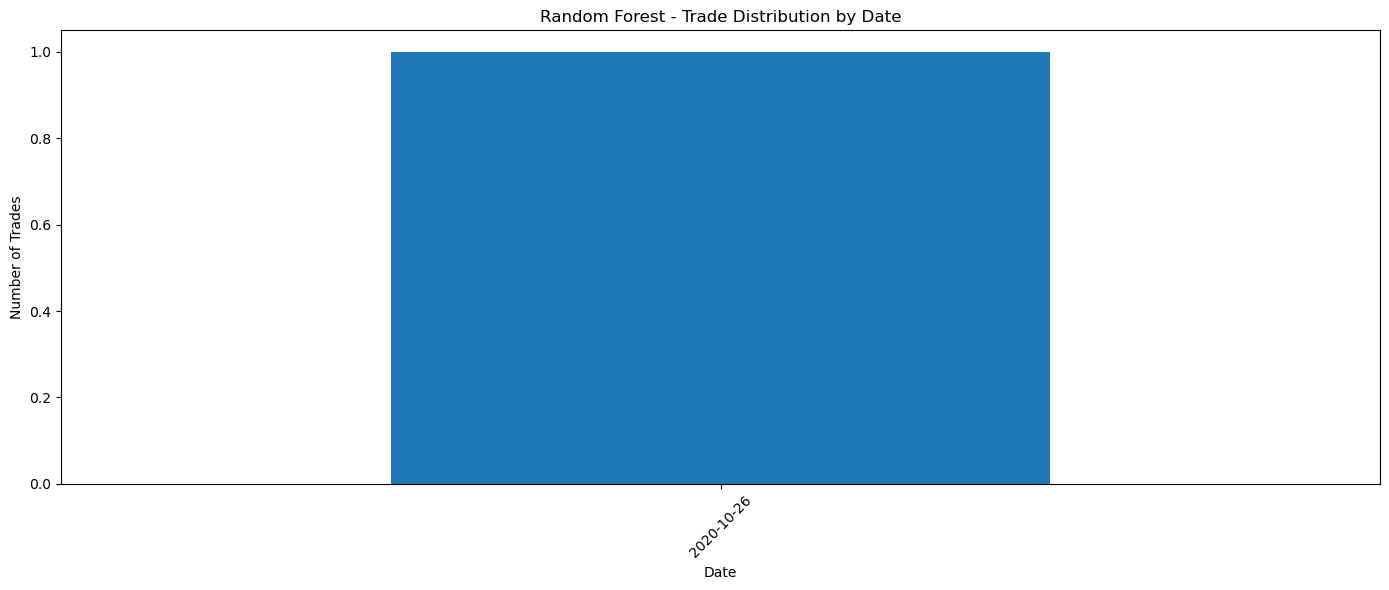

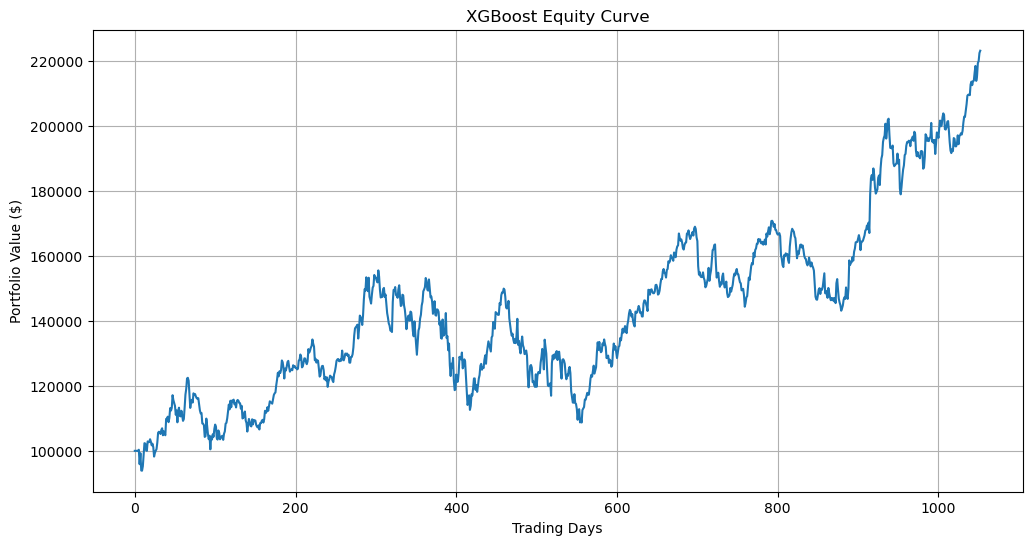

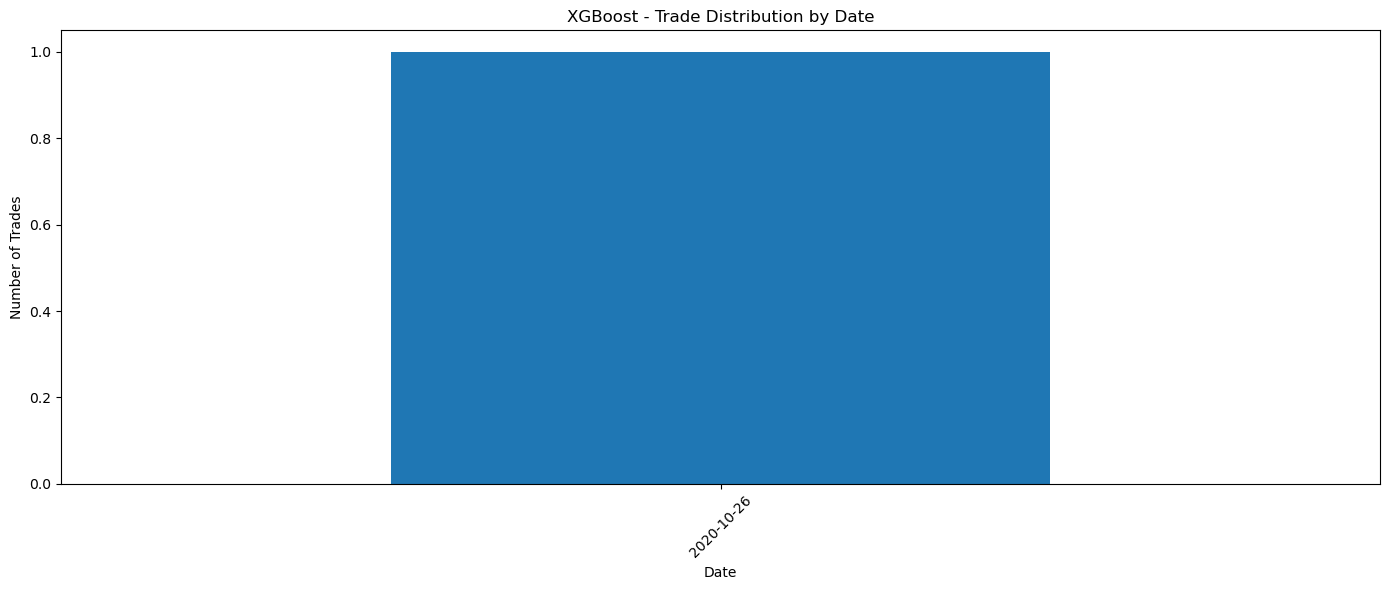

<Figure size 1400x800 with 0 Axes>

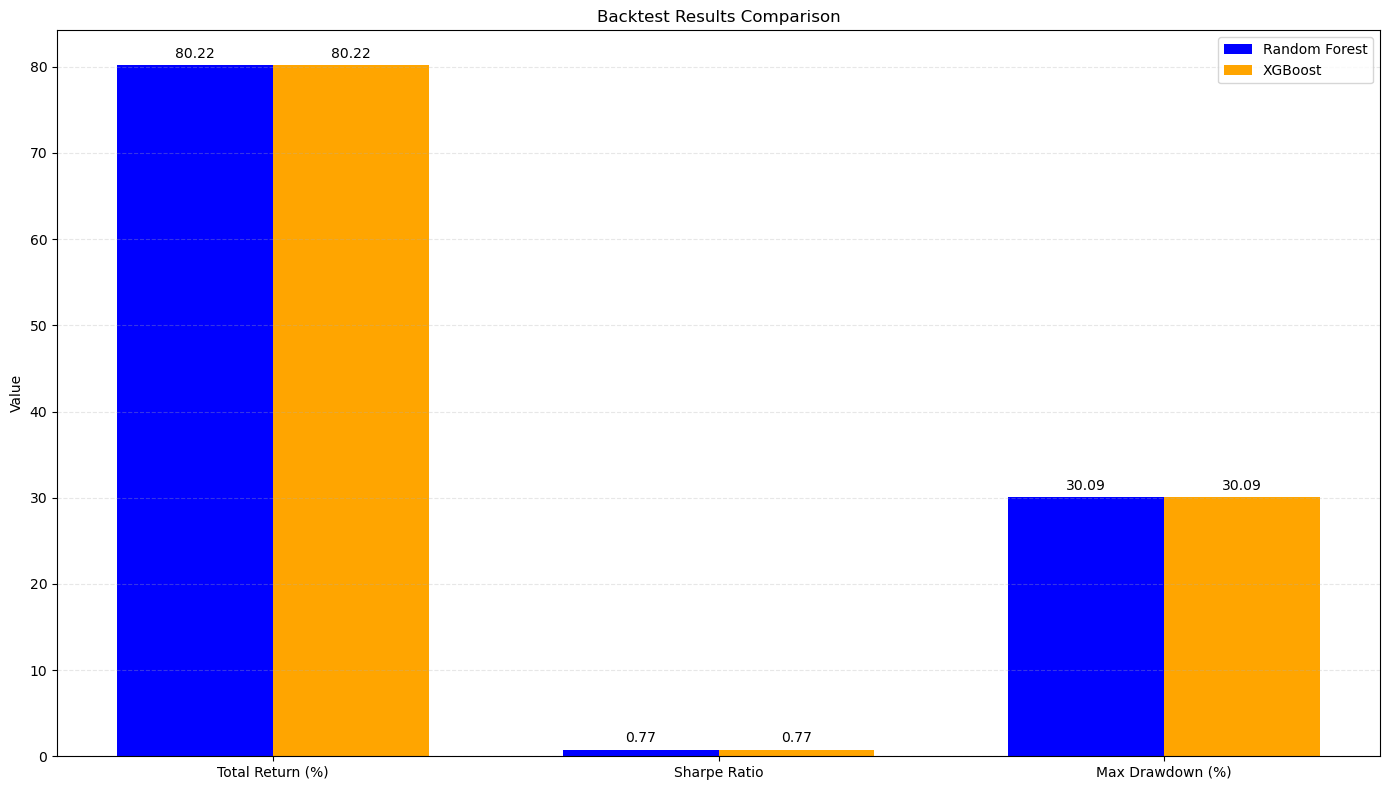

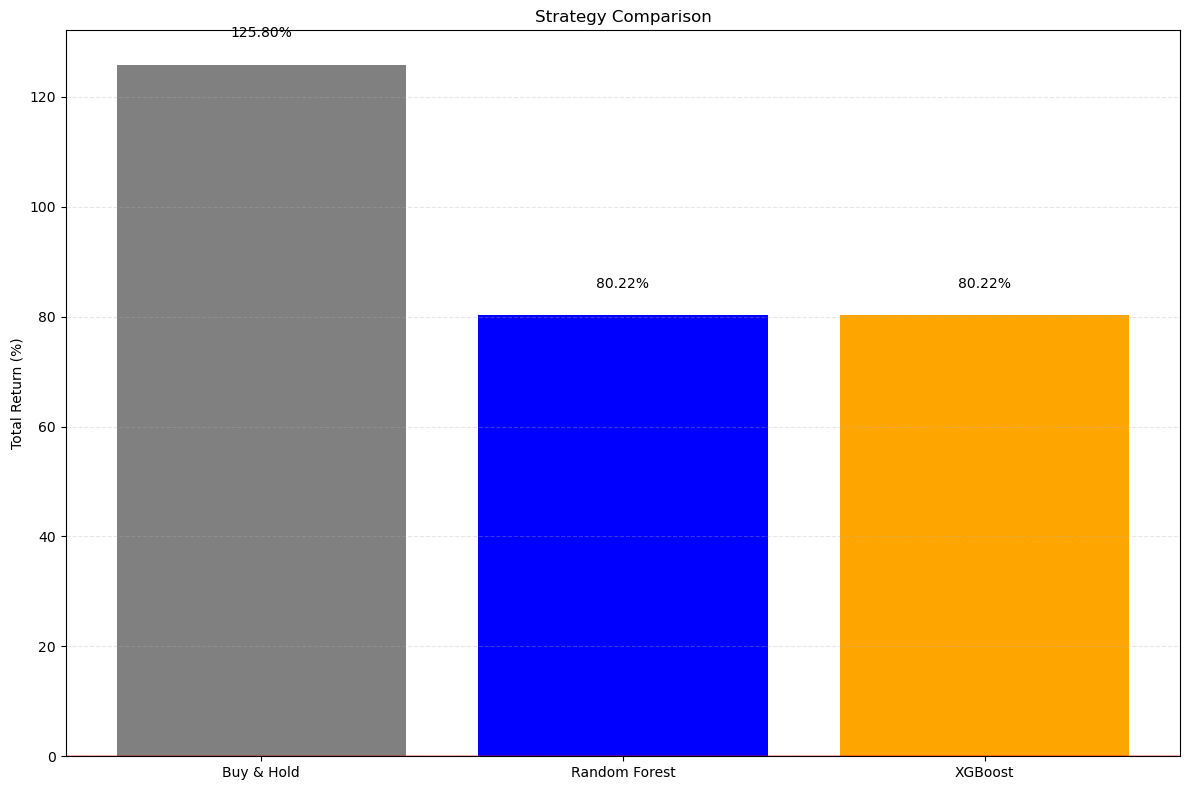

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import joblib
import backtrader as bt
from datetime import datetime

# Load data
print("Wczytywanie danych Apple...")
apple_data = pd.read_csv("apple_data_updated.csv", index_col=0, parse_dates=True)
print(f"Wczytano {len(apple_data)} wierszy danych")

# Prepare Data for Modeling
features = ['MA_10', 'MA_50', 'MA_200', 'RSI', 'MACD', 'Signal_Line', 'ADX', 'ATR', 'Sentiment_Proxy',
            'RSI_Lag_1', 'MACD_Lag_1', 'ADX_Lag_1', 'RSI_Lag_2', 'MACD_Lag_2', 'ADX_Lag_2',
            'RSI_Lag_3', 'MACD_Lag_3', 'ADX_Lag_3']

# Check for missing features and use only available ones
available_features = [f for f in features if f in apple_data.columns]
print(f"Używam {len(available_features)} z {len(features)} planowanych cech")

# Make sure we use data without missing values
valid_data = apple_data[available_features].dropna()
apple_data = apple_data.loc[valid_data.index]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(apple_data[available_features])

# Prepare target variable (3-day forward prediction)
target_column = 'Target_Up' if 'Target_Up' in apple_data.columns else 'Target'
print(f"Używam kolumny celu: {target_column}")

# Ensure feature and target sizes match
features_scaled = features_scaled[:-3]
apple_data_trimmed = apple_data.iloc[:-3]

X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    apple_data_trimmed[target_column], 
    test_size=0.2, 
    random_state=42
)

print("Starting Random Forest Optimization...")

# Random Forest Hyperparameter Optimization
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
rf_model = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    rf_params, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    random_state=42, 
    verbose=1,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_best = rf_model.best_estimator_
rf_score = rf_best.score(X_test, y_test)

y_pred_rf = rf_best.predict(X_test)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)

print("Random Forest tuning complete.")
print(f"Najlepsze parametry RF: {rf_model.best_params_}")
print(f"Dokładność Random Forest: {rf_score:.4f}")
print(classification_report(y_test, y_pred_rf))

print("\nStarting XGBoost Optimization...")

# XGBoost Hyperparameter Optimization
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 3, 5]
}
xgb_model = RandomizedSearchCV(
    xgb.XGBClassifier(
        eval_metric='logloss', 
        use_label_encoder=False, 
        random_state=42
    ), 
    xgb_params, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    random_state=42, 
    verbose=1,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_best = xgb_model.best_estimator_
xgb_score = xgb_best.score(X_test, y_test)

y_pred_xgb = xgb_best.predict(X_test)
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)

print("XGBoost tuning complete.")
print(f"Najlepsze parametry XGB: {xgb_model.best_params_}")
print(f"Dokładność XGBoost: {xgb_score:.4f}")
print(classification_report(y_test, y_pred_xgb))

# Save models
joblib.dump(rf_best, 'rf_best_model.pkl')
joblib.dump(xgb_best, 'xgb_best_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Visualize model performance
plt.figure(figsize=(10, 6))
models = ["Random Forest", "XGBoost"]
accuracies = [rf_score, xgb_score]
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0.5, 0.8)  # Set y-axis range to focus on accuracy differences
plt.ylabel("Accuracy")
plt.title("Optimized Model Accuracies")
plt.text(0, accuracies[0] + 0.005, f"{accuracies[0]:.4f}", ha='center', fontsize=12)
plt.text(1, accuracies[1] + 0.005, f"{accuracies[1]:.4f}", ha='center', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.savefig('model_accuracies.png')

# Feature importance for Random Forest
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_best.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')

# Feature importance for XGBoost
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': xgb_best.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png')

# Compare precision and recall
plt.figure(figsize=(12, 6))
metrics = ['precision_0', 'recall_0', 'precision_1', 'recall_1']
labels = ['Precision (spadek)', 'Recall (spadek)', 'Precision (wzrost)', 'Recall (wzrost)']
rf_values = [rf_report['0']['precision'], rf_report['0']['recall'], 
             rf_report['1']['precision'], rf_report['1']['recall']]
xgb_values = [xgb_report['0']['precision'], xgb_report['0']['recall'], 
              xgb_report['1']['precision'], xgb_report['1']['recall']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, rf_values, width, label='Random Forest', color='blue')
plt.bar(x + width/2, xgb_values, width, label='XGBoost', color='orange')

plt.ylabel('Value')
plt.title('Precision and Recall Comparison')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('precision_recall_comparison.png')

# Define Backtrader Strategy using the best model (determined by accuracy)
class MLModelStrategy(bt.Strategy):
    params = (
        ('slippage', 0.002),  # 0.2% slippage
        ('commission', 0.004),  # 0.4% commission
        ('model', None),       # ML model to use
        ('threshold', 0.5)     # Niższy próg dla większej liczby transakcji
    )
    
    def __init__(self):
        self.use_model = self.params.model
        print(f"Backtest using: {self.use_model.__class__.__name__}")
        
        # Przygotowanie danych do przewidywania
        self.data_features = scaler.transform(apple_data_trimmed[available_features])
        
        # Generowanie przewidywań i wyświetlenie statystyk
        self.probabilities = self.use_model.predict_proba(self.data_features)[:, 1]
        self.predictions = (self.probabilities > self.params.threshold).astype(int)
        
        buy_signals = sum(self.predictions)
        print(f"Total buy signals: {buy_signals} out of {len(self.predictions)} ({buy_signals/len(self.predictions)*100:.1f}%)")
        
        # Inicjalizacja zmiennych do śledzenia
        self.current_index = 0
        self.portfolio_values = []
        self.positions_log = []
        self.order = None
        
        # Dostęp do danych cenowych
        self.dataclose = self.datas[0].close
    
    def next(self):
        # Śledzimy wartość portfela
        self.portfolio_values.append(self.broker.get_value())
        
        # Pomijamy jeśli mamy oczekujące zlecenie
        if self.order:
            return
        
        # Pomijamy jeśli przekroczyliśmy liczbę predykcji
        if self.current_index >= len(self.predictions):
            return
        
        # Pobieramy predykcję dla bieżącego dnia
        prediction = self.predictions[self.current_index]
        probability = self.probabilities[self.current_index]
        
        # Logika handlowa
        if not self.position:  # Jeśli nie jesteśmy w rynku
            if prediction == 1:  # Model przewiduje wzrost
                cash = self.broker.getcash()
                price = self.dataclose[0]
                size = int(cash / price * 0.95)  # 95% dostępnej gotówki
                
                if size > 0:
                    self.order = self.buy(size=size)
                    self.log(f'BUY EXECUTED, Price: {price:.2f}, Size: {size}, Cash: {cash:.2f}, Prob: {probability:.2f}')
                else:
                    self.log(f'BUY SKIPPED - Size would be {size}, Price: {price:.2f}, Cash: {cash:.2f}')
        
        else:  # Jeśli jesteśmy w rynku
            if prediction == 0:  # Model przewiduje spadek
                self.order = self.sell()
                self.log(f'SELL EXECUTED, Price: {self.dataclose[0]:.2f}, Value: {self.broker.get_value():.2f}, Prob: {probability:.2f}')
        
        # Przechodzimy do następnej predykcji
        self.current_index += 1
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        log_entry = f'{dt.isoformat()}: {txt}'
        print(log_entry)  # Drukujemy do konsoli
        self.positions_log.append(log_entry)
    
    def stop(self):
        # Wywoływane po zakończeniu backtestingu
        print(f"Strategy finished with {len(self.positions_log)} trade signals")

def run_backtest(model, model_name, initial_cash=100000):
    cerebro = bt.Cerebro()
    
    # Dodajemy strategię
    cerebro.addstrategy(MLModelStrategy, model=model)
    
    # Tworzymy feed danych z DataFrame
    # Ważne upewnienie się, że kolumny są poprawnie zmapowane
    data = bt.feeds.PandasData(
        dataname=apple_data_trimmed,
        datetime=None,  # Użyj indeksu jako datetime
        open='Open',
        high='High',
        low='Low',
        close='Close',
        volume='Volume',
        openinterest=-1  # Brak danych o otwartym zainteresowaniu
    )
    cerebro.adddata(data)
    
    # Ustawiamy parametry brokera
    cerebro.broker.set_cash(initial_cash)
    cerebro.broker.setcommission(commission=0.004)
    cerebro.broker.set_slippage_perc(0.002)
    
    # Dodajemy analizatory
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    
    # Uruchamiamy backtest
    print(f"\nStarting {model_name} Backtest...")
    results = cerebro.run()
    strategy = results[0]
    
    # Pobieramy wyniki analizy z bezpieczną obsługą przypadków None
    sharpe_analysis = strategy.analyzers.sharpe.get_analysis()
    sharpe_ratio = sharpe_analysis.get('sharperatio', 0.0) or 0.0  # Defaultujemy do 0 jeśli None
    
    returns_analysis = strategy.analyzers.returns.get_analysis()
    total_return = (returns_analysis.get('rtot', 0.0) or 0.0) * 100
    
    drawdown_analysis = strategy.analyzers.drawdown.get_analysis()
    max_drawdown = drawdown_analysis.get('max', {}).get('drawdown', 0.0) or 0.0
    
    trade_analysis = strategy.analyzers.trades.get_analysis()
    total_trades = trade_analysis.get('total', {}).get('total', 0)
    
    final_value = cerebro.broker.get_value()
    
    print(f"{model_name} Backtest Complete.")
    print(f"Starting Portfolio Value: ${initial_cash:.2f}")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"Total Trades: {total_trades}")
    
    # Rysujemy wykres equity curve jeśli mamy dane
    if hasattr(strategy, 'portfolio_values') and len(strategy.portfolio_values) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(strategy.portfolio_values)
        plt.title(f'{model_name} Equity Curve')
        plt.xlabel('Trading Days')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.savefig(f'{model_name.lower()}_equity_curve.png')
    
    # Zapisujemy dziennik transakcji
    if hasattr(strategy, 'positions_log') and len(strategy.positions_log) > 0:
        with open(f'{model_name.lower()}_trade_log.txt', 'w') as f:
            for log_entry in strategy.positions_log:
                f.write(log_entry + '\n')
    else:
        print(f"Warning: No trades executed for {model_name}")
    
    # Sprawdzamy dzienny rozkład transakcji
    if hasattr(strategy, 'positions_log') and len(strategy.positions_log) > 0:
        dates = [entry.split(':')[0] for entry in strategy.positions_log]
        trade_dates = pd.Series(dates).value_counts().sort_index()
        plt.figure(figsize=(14, 6))
        trade_dates.plot(kind='bar')
        plt.title(f'{model_name} - Trade Distribution by Date')
        plt.xlabel('Date')
        plt.ylabel('Number of Trades')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'{model_name.lower()}_trades_by_date.png')
    
    return {
        'model': model_name,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'final_value': final_value,
        'trades_executed': total_trades
    }

# Choose the best model based on accuracy
best_model = rf_best if rf_score > xgb_score else xgb_best
best_model_name = "Random Forest" if rf_score > xgb_score else "XGBoost"

# Run backtests
rf_results = run_backtest(rf_best, "Random Forest")
xgb_results = run_backtest(xgb_best, "XGBoost")

# Compare backtest results
plt.figure(figsize=(14, 8))
comparison_metrics = ['total_return', 'sharpe_ratio', 'max_drawdown']
labels = ['Total Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)']

# Upewnij się, że wartości nie są None
rf_values = [
    rf_results['total_return'] or 0.0,
    rf_results['sharpe_ratio'] or 0.0,
    rf_results['max_drawdown'] or 0.0
]
xgb_values = [
    xgb_results['total_return'] or 0.0,
    xgb_results['sharpe_ratio'] or 0.0,
    xgb_results['max_drawdown'] or 0.0
]

x = np.arange(len(comparison_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, rf_values, width, label='Random Forest', color='blue')
rects2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost', color='orange')

ax.set_ylabel('Value')
ax.set_title('Backtest Results Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('backtest_comparison.png')

print("\nBacktest Comparison Summary:")
print(f"Random Forest Total Return: {rf_results['total_return']:.2f}%")
print(f"XGBoost Total Return: {xgb_results['total_return']:.2f}%")
print(f"Random Forest Sharpe Ratio: {rf_results['sharpe_ratio']:.4f}")
print(f"XGBoost Sharpe Ratio: {xgb_results['sharpe_ratio']:.4f}")
print(f"Random Forest Total Trades: {rf_results.get('trades_executed', 0)}")
print(f"XGBoost Total Trades: {xgb_results.get('trades_executed', 0)}")
print(f"Best Model for Trading: {'Random Forest' if rf_results['total_return'] > xgb_results['total_return'] else 'XGBoost'}")

# Buy and Hold Strategy for comparison
initial_investment = 100000
try:
    start_price = apple_data_trimmed['Close'].iloc[0]
    end_price = apple_data_trimmed['Close'].iloc[-1]
    buy_hold_return = ((end_price / start_price) - 1) * 100

    print(f"\nBuy and Hold Strategy:")
    print(f"Start Price: ${start_price:.2f}")
    print(f"End Price: ${end_price:.2f}")
    print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
    print(f"Buy & Hold Final Value: ${initial_investment * (1 + buy_hold_return/100):.2f}")

    # Final comparison with buy and hold
    plt.figure(figsize=(12, 8))
    strategies = ['Buy & Hold', 'Random Forest', 'XGBoost']
    returns = [buy_hold_return, rf_results['total_return'], xgb_results['total_return']]
    colors = ['grey', 'blue', 'orange']

    plt.bar(strategies, returns, color=colors)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.ylabel('Total Return (%)')
    plt.title('Strategy Comparison')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Add value labels
    for i, v in enumerate(returns):
        plt.text(i, v + (5 if v > 0 else -10), f'{v:.2f}%', ha='center')

    plt.tight_layout()
    plt.savefig('strategy_comparison.png')
except Exception as e:
    print(f"Error calculating Buy & Hold strategy: {str(e)}")

print("\nAnalysis complete! All results have been saved as images.")